# Chapter 13 - Tectonic-scale models and modelling tools

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.optimize import fsolve
from scipy.special import lambertw
from scipy.integrate import odeint

## Corner-flow with magmatic segregation

In [7]:
def vsr(alph, theta):
    return -(2.*np.sin(alph)**2 * np.cos(theta) - 2.*np.cos(theta) 
             + 2.*theta*np.sin(theta))/(2.*alph - np.pi + np.sin(2.*alph))

def vst(alph, theta):
    return (2.*np.sin(alph)**2 * np.sin(theta) - 2.*theta*np.cos(theta))/(2.*alph - np.pi + np.sin(2.*alph))

def vlr(alph, theta, r, e):
    sin_a = np.sin(alph)
    sin_t = np.sin(theta)
    cos_t = np.cos(theta)
    numer = 2.*sin_a**2 * cos_t - 2.*cos_t + 2.*theta*sin_t
    denom = 2.*alph - np.pi + np.sin(2.*alph)
    return -numer/denom - (cos_t - ((numer/denom - (2.*sin_a**2 * cos_t - 6.*cos_t + 2.*theta*sin_t)/denom))/r**2)/e

def vlt(alph, theta, r, e):
    sin_t = np.sin(theta)
    sin_a = np.sin(alph)
    cos_t = np.cos(theta)
    numer = -2.*sin_a**2 * sin_t + 2.*theta*cos_t
    denom = 2.*alph - np.pi + np.sin(2.*alph)
    return (sin_t - ((4.*sin_t + numer)/denom - (8.*sin_t + numer)/denom)/r**2)/e - numer/denom

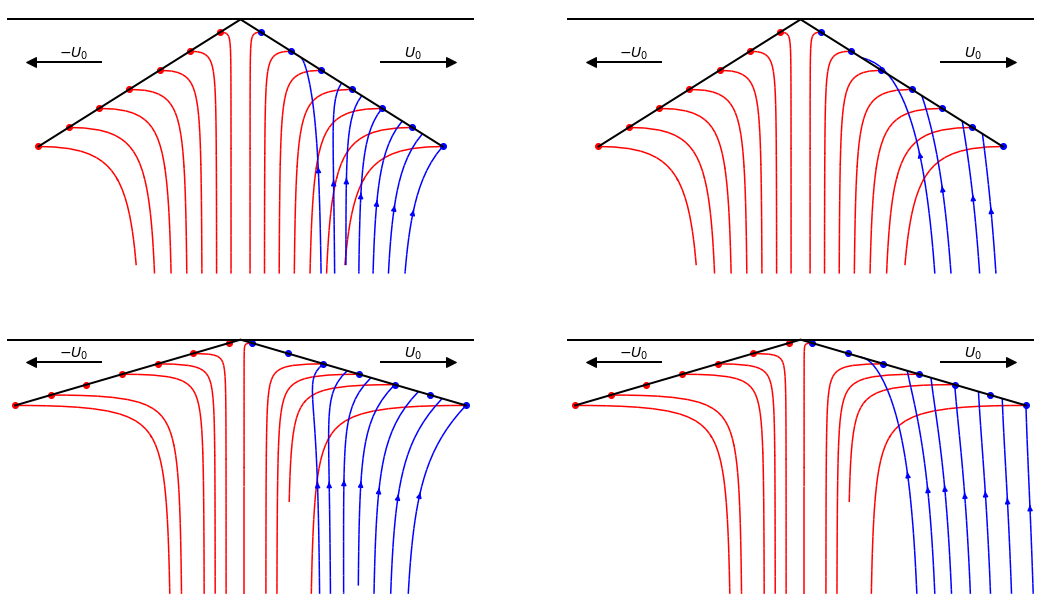

In [82]:
f, ax = plt.subplots(2, 2)
zoom = 2.0
f.set_size_inches(9.2 * zoom, 5.4 * zoom)
f.set_facecolor('w')

Ny = 500
aspect = 2.0
Nx = np.round(Ny*aspect)
x = np.linspace(-0.5*aspect, 0.5*aspect, Nx)
y = np.linspace(0.0, 1.0, Ny)
X, Y = np.meshgrid(x, y)
theta = -np.arctan2(Y, X) + 0.5*np.pi

seedVS = np.zeros([7, 2])
seedVL = np.zeros([10, 2])

L = 0.2
evec = np.asarray([1, 0.01])
alphvec = np.asarray([30*np.pi/180., 15*np.pi/180.])
r = np.sqrt(X**2 + Y**2)/L

for i, alph in enumerate(alphvec):
    B = 2./(np.pi - 2*alph - np.sin(2.*alph))
    inplates = np.fabs(theta) > (0.5 * np.pi - alph)
    Lf = L * np.sqrt(2*B)
    for j, e in enumerate(evec):
        VSR = vsr(alph, theta)
        VST = vst(alph, theta)
        VLR = vlr(alph, theta, r, e)
        VLT = vlt(alph, theta, r, e)
        VSX = VSR * np.sin(theta) + VST * np.cos(theta)
        VSY = VSR * np.cos(theta) - VST * np.sin(theta)
        VLX = VLR * np.sin(theta) + VLT * np.cos(theta)
        VLY = VLR * np.cos(theta) - VLT * np.sin(theta)            

        sm = 0.2 * np.minimum(np.sin(alph), np.cos(alph))
        
        # -----------------
        # solid streamlines
        # -----------------
        # in the positive X axis
        seedVS[:, 0] = np.linspace(sm*np.cos(alph), np.cos(alph), 7)
        seedVS[:, 1] = np.linspace(sm*np.sin(alph), np.sin(alph), 7)
        ax[i, j].plot(seedVS[:, 0], seedVS[:, 1], 'bo')
        ax[i, j].streamplot(X, Y, VSX, VSY, start_points=seedVS, color='r', 
                            integration_direction='backward', minlength=0.5, arrowstyle='-')
        # in the negative X axis
        seedVS[:, 0] = np.linspace(-np.cos(alph), -sm*np.cos(alph), 7)
        seedVS[:, 1] = np.flip(np.linspace(sm*np.sin(alph), np.sin(alph), 7))
        ax[i, j].plot(seedVS[:, 0], seedVS[:, 1], 'ro')
        ax[i, j].streamplot(X, Y, VSX, VSY, start_points=seedVS, color='r', 
                            integration_direction='backward', minlength=0.5, arrowstyle='-')
        
        # ------------------
        # liquid streamlines
        # ------------------
        # in the positive X axis
        seedVL[:, 0] = np.linspace(sm*np.cos(alph), np.cos(alph), 10)
        seedVL[:, 1] = np.linspace(sm*np.sin(alph), np.sin(alph), 10)
        ax[i, j].streamplot(X, Y, VLX, VLY, start_points=seedVL, color='b', 
                            integration_direction='backward', minlength=0.5)
        # in the negative X axis
        seedVL[:, 0] = 0.0  # np.linspace(-np.cos(alph), -sm*np.cos(alph), 10)
        seedVL[:, 1] = 0.0  # np.flip(np.linspace(sm*np.sin(alph), np.sin(alph), 10))
        ax[i, j].streamplot(X, Y, VSX, VSY, start_points=seedVL, color='b', 
                            integration_direction='backward', minlength=0.5)
        
        # annotations
        ax[i, j].plot([-1., 1.], [0., 0.], '-k', linewidth=2)
        ax[i, j].plot([-np.cos(alph), 0., np.cos(alph)], [np.sin(alph), 0., np.sin(alph)], '-k', linewidth=2)
        # U_0 line
        ax[i, j].plot([0.6, 0.9], [np.sin(alph)/3., np.sin(alph)/3.], '-k', linewidth=2)
        ax[i, j].plot(0.9, np.sin(alph)/3., '>k', markersize=10, markerfacecolor='k')
        ax[i, j].annotate(r'$U_0$', xy=[0.7, np.sin(alph)/3.0], fontsize=14, verticalalignment='bottom')
        # -U_0 line
        ax[i, j].plot([-0.6, -0.9], [np.sin(alph)/3., np.sin(alph)/3.], '-k', linewidth=2)
        ax[i, j].plot(-0.9, np.sin(alph)/3., '<k', markersize=10, markerfacecolor='k')
        ax[i, j].annotate(r'$-U_0$', xy=[-0.65, np.sin(alph)/3.0], fontsize=14, verticalalignment='bottom', 
                          horizontalalignment='right')
        # axes
        ax[i, j].set_xlim(-0.5*aspect, 0.5*aspect)
        ax[i, j].set_ylim(-0.05, 1.0)
        ax[i, j].set_axis_off()
        ax[i, j].invert_yaxis()

## Melt focusing through a sub-lithospheric channel

### Lateral transport in semi-infinite half-space

### Lateral transport to a mid-ocean ridge